## This notebook shows how to load the dataset TDvsCPu and then training 3 Nets with evaluations
## For others datasets, just load the other dataset and change the name of dataset.
## All models are trained. So the training process has been commented. You can uncomment it in case of needed.

## Load the dataset and split the data to train, validation, and test sets.

In [5]:
from utils.utils import gait_dataloader
from utils.utils import init_model,  patients_idx_to_cycles_idx, find_cycles_idx_by_patient_idx
from sklearn.model_selection import train_test_split

from utils.utils import init_model,accuracy_end_to_end
import os
import numpy as np

from sklearn.metrics import f1_score

from sklearn.metrics import roc_auc_score
from sklearn.metrics import recall_score

from sklearn.metrics import accuracy_score

from sklearn.metrics import confusion_matrix

import seaborn as sn

from utils.utils import *

def load_dataset_v1(dir_dataset,channel_first=True,flatten=True,shuffle=False,random_state=0):
    index = [0,1,2,3,4,5,6,7,8,9,14,15,16,17,18,19,20,21,22,23,24,29]
    
    npzfile = np.load(dir_dataset + 'RightPC.npz')
    
    x_train_all = npzfile['Input']
    y_train = npzfile['Output']
    y_train = np.ravel(y_train)
    x_train = x_train_all[:,:,index]
    if channel_first:
        x_train = x_train.transpose(0,2,1)
    
    npzfile = np.load(dir_dataset + 'LeftPC.npz')
    x_val_all = npzfile['Input']
    y_val = npzfile['Output']
    y_val = np.ravel(y_val)
    x_val = x_val_all[:,:,index]
    if channel_first:
        x_val = x_val.transpose(0,2,1)
    
    npzfile = np.load(dir_dataset + 'TD.npz')
    x_test_all = npzfile['Input']
    y_test = npzfile['Output']
    y_test = np.ravel(y_test)
    x_test = x_test_all[:,:,index]
    if channel_first:
        x_test = x_test.transpose(0,2,1)
    
    if flatten == True:
        x_train = x_train.reshape([x_train.shape[0],-1])
        x_val = x_val.reshape([x_val.shape[0],-1])
        x_test = x_test.reshape([x_test.shape[0],-1])
    
    nb_classes = len(np.unique(np.concatenate((y_train, y_val, y_test), axis=0)))
    
    return x_train, y_train ,x_val, y_val, x_test, y_test, nb_classes

dataset = "archives/AQM/TDvsPC_new_no_shuffle/"

x_R, y_R ,x_L , y_L, x_TD, y_TD, nb_classes = load_dataset_v1(dataset,channel_first=True,flatten=False,shuffle=False,random_state=0)

X_d = np.concatenate([x_R,x_L,x_TD])
# X_d = X_d.reshape([len(X_d),-1])
y_d = np.concatenate([y_R,y_L,y_TD])
import  pandas as pd

# R_data = pd.read_csv('DataPC - Right.csv', header=None)
# R_idx = R_data[2].to_numpy()


CP_data = pd.read_csv('DataCP - all.csv', header=None)
CP_idx = CP_data[1].to_numpy()

TD_data = pd.read_csv('DataTD - By Subject.csv', header=None)
TD_idx = TD_data[1].to_numpy()
TD_idx = TD_idx + CP_idx[-1]

cycle_end_idx = np.concatenate([CP_idx,TD_idx])
cycle_end_idx

patient_index_range = np.arange(len(CP_idx)+len(TD_idx))
patient_class = np.concatenate([np.ones(len(CP_idx)), np.zeros(len(TD_idx))])

x_train, x_test, y_train, y_test = train_test_split(patient_index_range, patient_class, test_size=0.4, stratify=patient_class,random_state=0)
x_val, x_test, y_val, y_test = train_test_split(x_test,y_test, test_size=0.75, random_state=0, stratify=y_test)
print(np.unique(y_train,return_counts=True))
print(np.unique(y_val,return_counts=True))
print(np.unique(y_test,return_counts=True))

(array([0., 1.]), array([35, 89]))
(array([0., 1.]), array([ 6, 14]))
(array([0., 1.]), array([18, 45]))


## Print the number of cycles in each set

In [6]:
print("train set")
print("0-",len(patients_idx_to_cycles_idx(x_train[np. where(y_train == 0)],cycle_end_idx)))
print("1-",len(patients_idx_to_cycles_idx(x_train[np. where(y_train == 1)],cycle_end_idx)))
print(len(patients_idx_to_cycles_idx(x_train,cycle_end_idx)))

print("val set")
print("0-",len(patients_idx_to_cycles_idx(x_val[np. where(y_val == 0)],cycle_end_idx)))
print("1-",len(patients_idx_to_cycles_idx(x_val[np. where(y_val == 1)],cycle_end_idx)))
print(len(patients_idx_to_cycles_idx(x_val,cycle_end_idx)))

print("test set")
print("0-",len(patients_idx_to_cycles_idx(x_test[np. where(y_test == 0)],cycle_end_idx)))
print("1-",len(patients_idx_to_cycles_idx(x_test[np. where(y_test == 1)],cycle_end_idx)))
print(len(patients_idx_to_cycles_idx(x_test,cycle_end_idx)))


train set
0- 375
1- 1637
2012
val set
0- 76
1- 279
355
test set
0- 199
1- 813
1012


## Define the function to train and evaluate the model

In [7]:
def train_model(D_name,Net_name):
    a_list = []
    for i in range(10):
        print("train number -", i)
        classifer = init_model(model_name=Net_name,lr_reduce=True, earlystopping=True, lr_patience=1, batch_size=32,lr=0.001, max_epochs=50,default_root_dir="./new_train_lrR_ET_"+D_name+"_"+Net_name+"/",nb_classes=2)
        classifer.fit(X_d[patients_idx_to_cycles_idx(x_train,cycle_end_idx)], y_d[patients_idx_to_cycles_idx(x_train,cycle_end_idx)], X_d[patients_idx_to_cycles_idx(x_val,cycle_end_idx)], y_d[patients_idx_to_cycles_idx(x_val,cycle_end_idx)],ckpt_monitor='val_accuracy')
#         a_list.append(accuracy_score(y_d[patients_idx_to_cycles_idx(x_test,cycle_end_idx)], classifer.predict(X_d[patients_idx_to_cycles_idx(x_test,cycle_end_idx)])))
        print("train number end -", i)

from sklearn.metrics import f1_score

def eval_model(D_name,Net_name):
    
    list_f1 = []
    list_accuracy = []

    import os
    filePath = "./new_train_lrR_ET_"+D_name+"_"+Net_name+"/"
    os.listdir(filePath)

    for i in os.listdir(filePath):
        if 'model' in i:
            print(i)
            classifer = init_model(model_name=Net_name).load( "./new_train_lrR_ET_"+D_name+"_"+Net_name+"/"+str(i),nb_classes=2)
            list_accuracy.append(accuracy_score(y_d[patients_idx_to_cycles_idx(x_test,cycle_end_idx)], classifer.predict(X_d[patients_idx_to_cycles_idx(x_test,cycle_end_idx)])))
            list_f1.append(f1_score(y_d[patients_idx_to_cycles_idx(x_test,cycle_end_idx)], classifer.predict(X_d[patients_idx_to_cycles_idx(x_test,cycle_end_idx)])))
    return list_accuracy, "%.4f" %(np.mean(list_accuracy)) +"±"+ "%.4f" %(np.std(list_accuracy)),list_f1 , "%.4f" %(np.mean(list_f1)) +"±"+ "%.4f" %(np.std(list_f1))

def batch_predict(images,model_path):
    pred_set = Dataset_torch(images,with_label=False)
    data_loader_pred = torch.utils.data.DataLoader(dataset=pred_set, batch_size=64,num_workers=4)
    
    
    classifer = init_model(model_name=Net_name,nb_classes=2).load(model_path)
    
    trainer = pl.Trainer()
    pred = trainer.predict(model=classifer.model,dataloaders = data_loader_pred)
    pred = torch.cat(pred)
    return pred.detach().cpu().numpy()

from torch.utils.data import Dataset
from utils.utils import gait_dataloader
from utils.utils import init_model
## lime
import torch
import pytorch_lightning as pl
class Dataset_torch(Dataset):

    def __init__(self, data,with_label=True):
        self.with_label =  with_label
        
        if self.with_label:
            self.data_x, self.data_y = data
        else:
            self.data_x = data
    def __len__(self):
        return len(self.data_x)

    def __getitem__(self, idx):
        if self.with_label:
            return self.data_x[idx], self.data_y[idx]
        else:
            return self.data_x[idx]

def eval_model_5_bundle(D_name,Net_name,idx=None):
    
    list_f1 = []
    list_accuracy = []

    import os
    filePath = "./new_train_lrR_ET_"+D_name+"_"+Net_name+"/"
    model_list = os.listdir(filePath)
    model_list.remove('logs')
    if 'prediction.npy' in model_list:
        model_list.remove('prediction.npy')
    proba_sum_list = []
    if idx==None:
        for index in range(10):
            print(index)
            proba_sum = np.zeros([len(y_d[patients_idx_to_cycles_idx(x_test,cycle_end_idx)]),2])
            for j in range(5):

                print(model_list[index])
    #             classifer = init_model(model_name=Net_name).load( "./new_train_lrR_ET_"+D_name+"_"+Net_name+"/"+model_list[index*5+j])
                print(batch_predict(X_d[patients_idx_to_cycles_idx(x_test,cycle_end_idx)],"./new_train_lrR_ET_"+D_name+"_"+Net_name+"/"+model_list[index*5+j]))
                proba_sum +=batch_predict(X_d[patients_idx_to_cycles_idx(x_test,cycle_end_idx)],"./new_train_lrR_ET_"+D_name+"_"+Net_name+"/"+model_list[index*5+j])/5
            proba_sum_list.append(proba_sum)
    else:
            index = idx
            print(index)
            proba_sum = np.zeros([len(y_d[patients_idx_to_cycles_idx(x_test,cycle_end_idx)]),3])
            for j in range(5):

                print(model_list[index])
    #             classifer = init_model(model_name=Net_name).load( "./new_train_lrR_ET_"+D_name+"_"+Net_name+"/"+model_list[index*5+j])
                print(batch_predict(X_d[patients_idx_to_cycles_idx(x_test,cycle_end_idx)],"./new_train_lrR_ET_"+D_name+"_"+Net_name+"/"+model_list[index*5+j]))
                proba_sum +=batch_predict(X_d[patients_idx_to_cycles_idx(x_test,cycle_end_idx)],"./new_train_lrR_ET_"+D_name+"_"+Net_name+"/"+model_list[index*5+j])/5
            proba_sum_list = (proba_sum)
    return proba_sum_list

## Train and evaluate the model
### To train the model, just uncommented the 
### "     for j in range(5):
###         train_model(D_name=D_name,Net_name=Net_name)"

In [8]:
D_name_add = 'TDvsCPu'
D_name = D_name_add+"_full_5"
Net_name_list = ['ResNet']

for Net_name in Net_name_list:
    # for j in range(5):
    #     train_model(D_name=D_name,Net_name=Net_name)
    out = eval_model_5_bundle(D_name,Net_name)
    np.save( './new_train_lrR_ET_'+D_name+'_'+Net_name+'/prediction.npy' ,out)

/home/zylan/Desktop/paper1/classifiers/DL_classifier.py:60: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_dir,map_location=torch.device('cpu'))

0
model-epoch=04-val_loss=0.22-val_accuracy=0.94.ckpt
Predicting DataLoader 0:   6%|█▏                 | 1/16 [00:00<00:00, 22.37it/s]

/home/zylan/anaconda3/envs/env_gait/lib/python3.9/site-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Predicting DataLoader 0: 100%|██████████████████| 16/16 [00:00<00:00, 96.43it/s]
[[0.08313779 0.9168622 ]
 [0.06514424 0.9348557 ]
 [0.10174575 0.8982543 ]
 ...
 [0.04920441 0.9507956 ]
 [0.03634876 0.96365124]
 [0.04836187 0.9516381 ]]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|█████████████████| 16/16 [00:00<00:00, 117.54it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



model-epoch=04-val_loss=0.22-val_accuracy=0.94.ckpt
Predicting DataLoader 0: 100%|█████████████████| 16/16 [00:00<00:00, 119.16it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



[[0.06316563 0.9368344 ]
 [0.04279386 0.95720613]
 [0.02765737 0.9723426 ]
 ...
 [0.06773807 0.9322619 ]
 [0.05138767 0.94861233]
 [0.05908206 0.9409179 ]]
Predicting DataLoader 0: 100%|█████████████████| 16/16 [00:00<00:00, 127.98it/s]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


model-epoch=04-val_loss=0.22-val_accuracy=0.94.ckpt
Predicting DataLoader 0: 100%|█████████████████| 16/16 [00:00<00:00, 118.65it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



[[0.08314899 0.916851  ]
 [0.04445691 0.9555431 ]
 [0.06856368 0.93143636]
 ...
 [0.03839188 0.9616082 ]
 [0.0142426  0.98575735]
 [0.02421374 0.97578627]]
Predicting DataLoader 0: 100%|█████████████████| 16/16 [00:00<00:00, 118.12it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



model-epoch=04-val_loss=0.22-val_accuracy=0.94.ckpt
Predicting DataLoader 0: 100%|█████████████████| 16/16 [00:00<00:00, 127.73it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



[[0.01364896 0.9863511 ]
 [0.00603497 0.9939651 ]
 [0.00447407 0.9955259 ]
 ...
 [0.02756827 0.97243166]
 [0.00931023 0.99068975]
 [0.01593841 0.98406154]]
Predicting DataLoader 0: 100%|█████████████████| 16/16 [00:00<00:00, 135.22it/s]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


model-epoch=04-val_loss=0.22-val_accuracy=0.94.ckpt
Predicting DataLoader 0: 100%|█████████████████| 16/16 [00:00<00:00, 118.50it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



[[0.07084388 0.9291561 ]
 [0.0258412  0.97415876]
 [0.22146985 0.7785302 ]
 ...
 [0.1360559  0.8639441 ]
 [0.01216847 0.98783153]
 [0.03975999 0.96024007]]
Predicting DataLoader 0: 100%|█████████████████| 16/16 [00:00<00:00, 132.86it/s]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


1
model-epoch=04-val_loss=0.23-val_accuracy=0.92.ckpt
Predicting DataLoader 0: 100%|█████████████████| 16/16 [00:00<00:00, 129.56it/s]
[[0.22502506 0.77497494]
 [0.13356574 0.8664343 ]
 [0.14038281 0.8596172 ]
 ...
 [0.11227737 0.8877227 ]
 [0.08687685 0.9131231 ]
 [0.09143196 0.908568  ]]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|█████████████████| 16/16 [00:00<00:00, 119.86it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



model-epoch=04-val_loss=0.23-val_accuracy=0.92.ckpt
Predicting DataLoader 0: 100%|█████████████████| 16/16 [00:00<00:00, 121.52it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



[[0.17390835 0.82609165]
 [0.13154852 0.8684515 ]
 [0.14596993 0.8540301 ]
 ...
 [0.02923621 0.9707638 ]
 [0.01800037 0.98199964]
 [0.02713604 0.972864  ]]
Predicting DataLoader 0: 100%|█████████████████| 16/16 [00:00<00:00, 116.22it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



model-epoch=04-val_loss=0.23-val_accuracy=0.92.ckpt
Predicting DataLoader 0: 100%|█████████████████| 16/16 [00:00<00:00, 122.99it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



[[0.0931014  0.9068986 ]
 [0.14997439 0.85002565]
 [0.05449647 0.9455036 ]
 ...
 [0.13753495 0.8624651 ]
 [0.13143241 0.8685675 ]
 [0.15749441 0.8425056 ]]
Predicting DataLoader 0: 100%|█████████████████| 16/16 [00:00<00:00, 126.37it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



model-epoch=04-val_loss=0.23-val_accuracy=0.92.ckpt
Predicting DataLoader 0: 100%|█████████████████| 16/16 [00:00<00:00, 117.27it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



[[0.11872054 0.8812794 ]
 [0.1567236  0.8432764 ]
 [0.14073054 0.8592695 ]
 ...
 [0.01013737 0.9898627 ]
 [0.00470935 0.99529064]
 [0.00625913 0.99374086]]
Predicting DataLoader 0: 100%|█████████████████| 16/16 [00:00<00:00, 123.27it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



model-epoch=04-val_loss=0.23-val_accuracy=0.92.ckpt
Predicting DataLoader 0: 100%|█████████████████| 16/16 [00:00<00:00, 118.64it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



[[0.22752349 0.7724765 ]
 [0.22142161 0.77857834]
 [0.17806858 0.8219314 ]
 ...
 [0.0347255  0.9652745 ]
 [0.02037588 0.97962415]
 [0.04399813 0.95600194]]
Predicting DataLoader 0: 100%|█████████████████| 16/16 [00:00<00:00, 113.35it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2
model-epoch=04-val_loss=0.33-val_accuracy=0.89.ckpt
Predicting DataLoader 0: 100%|█████████████████| 16/16 [00:00<00:00, 115.65it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



[[0.16853997 0.83146006]
 [0.11177549 0.8882245 ]
 [0.13785449 0.86214554]
 ...
 [0.07221475 0.9277852 ]
 [0.07126017 0.9287398 ]
 [0.15867418 0.8413258 ]]
Predicting DataLoader 0: 100%|█████████████████| 16/16 [00:00<00:00, 117.80it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



model-epoch=04-val_loss=0.33-val_accuracy=0.89.ckpt
Predicting DataLoader 0: 100%|█████████████████| 16/16 [00:00<00:00, 123.32it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



[[0.5537781  0.44622186]
 [0.5592674  0.44073257]
 [0.56796885 0.43203118]
 ...
 [0.1987307  0.80126923]
 [0.1583668  0.8416332 ]
 [0.2278662  0.77213377]]
Predicting DataLoader 0: 100%|█████████████████| 16/16 [00:00<00:00, 123.62it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



model-epoch=04-val_loss=0.33-val_accuracy=0.89.ckpt
Predicting DataLoader 0: 100%|█████████████████| 16/16 [00:00<00:00, 125.30it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



[[0.23102735 0.76897264]
 [0.09699745 0.9030025 ]
 [0.11026756 0.8897324 ]
 ...
 [0.01401581 0.98598427]
 [0.01822363 0.9817764 ]
 [0.01576672 0.9842332 ]]
Predicting DataLoader 0: 100%|█████████████████| 16/16 [00:00<00:00, 126.83it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



model-epoch=04-val_loss=0.33-val_accuracy=0.89.ckpt
Predicting DataLoader 0: 100%|█████████████████| 16/16 [00:00<00:00, 132.65it/s]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


[[0.0524432  0.94755685]
 [0.04506287 0.95493716]
 [0.04109086 0.95890915]
 ...
 [0.06605743 0.9339426 ]
 [0.05337747 0.9466225 ]
 [0.05899475 0.94100523]]
Predicting DataLoader 0: 100%|█████████████████| 16/16 [00:00<00:00, 114.52it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



model-epoch=04-val_loss=0.33-val_accuracy=0.89.ckpt
Predicting DataLoader 0: 100%|█████████████████| 16/16 [00:00<00:00, 162.46it/s]
[[0.06041003 0.93959004]
 [0.01899603 0.98100394]
 [0.0595252  0.94047475]
 ...
 [0.02030343 0.9796966 ]
 [0.0121956  0.9878044 ]
 [0.01649171 0.98350835]]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|█████████████████| 16/16 [00:00<00:00, 135.59it/s]
3
model-epoch=03-val_loss=0.40-val_accuracy=0.94.ckpt


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|█████████████████| 16/16 [00:00<00:00, 117.57it/s]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


[[0.0912615  0.9087385 ]
 [0.07526244 0.9247376 ]
 [0.07161792 0.9283821 ]
 ...
 [0.19356012 0.8064398 ]
 [0.16201901 0.837981  ]
 [0.20210281 0.7978972 ]]
Predicting DataLoader 0: 100%|█████████████████| 16/16 [00:00<00:00, 148.07it/s]
model-epoch=03-val_loss=0.40-val_accuracy=0.94.ckpt


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|█████████████████| 16/16 [00:00<00:00, 132.71it/s]
[[0.03045844 0.96954155]
 [0.04110821 0.9588918 ]
 [0.0371515  0.96284854]
 ...
 [0.05243744 0.9475625 ]
 [0.02395949 0.9760405 ]
 [0.0626136  0.9373864 ]]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|█████████████████| 16/16 [00:00<00:00, 143.43it/s]
model-epoch=03-val_loss=0.40-val_accuracy=0.94.ckpt


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|█████████████████| 16/16 [00:00<00:00, 137.53it/s]
[[0.5888711  0.41112888]
 [0.4143642  0.5856358 ]
 [0.3332567  0.66674334]
 ...
 [0.12070419 0.8792958 ]
 [0.10626385 0.8937361 ]
 [0.10419673 0.8958033 ]]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|█████████████████| 16/16 [00:00<00:00, 136.46it/s]
model-epoch=03-val_loss=0.40-val_accuracy=0.94.ckpt


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|█████████████████| 16/16 [00:00<00:00, 127.76it/s]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


[[0.0263559  0.9736441 ]
 [0.01452636 0.98547363]
 [0.03368931 0.9663107 ]
 ...
 [0.00540892 0.9945911 ]
 [0.00380359 0.9961964 ]
 [0.00652873 0.99347126]]
Predicting DataLoader 0: 100%|█████████████████| 16/16 [00:00<00:00, 124.61it/s]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


model-epoch=03-val_loss=0.40-val_accuracy=0.94.ckpt
Predicting DataLoader 0: 100%|█████████████████| 16/16 [00:00<00:00, 131.58it/s]
[[0.07057369 0.9294263 ]
 [0.06676855 0.9332314 ]
 [0.01215305 0.987847  ]
 ...
 [0.01684311 0.98315686]
 [0.015353   0.98464704]
 [0.02450704 0.9754929 ]]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|█████████████████| 16/16 [00:00<00:00, 135.83it/s]
4
model-epoch=06-val_loss=0.28-val_accuracy=0.94.ckpt


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|█████████████████| 16/16 [00:00<00:00, 143.65it/s]
[[0.3705118  0.6294881 ]
 [0.36470094 0.635299  ]
 [0.05543092 0.94456905]
 ...
 [0.06657723 0.9334228 ]
 [0.03984175 0.9601583 ]
 [0.09051789 0.90948206]]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|█████████████████| 16/16 [00:00<00:00, 149.85it/s]
model-epoch=06-val_loss=0.28-val_accuracy=0.94.ckpt


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|█████████████████| 16/16 [00:00<00:00, 121.52it/s]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


[[0.23170021 0.76829976]
 [0.0744645  0.92553556]
 [0.0967432  0.9032568 ]
 ...
 [0.01800025 0.98199975]
 [0.0092096  0.99079037]
 [0.01534905 0.98465097]]
Predicting DataLoader 0: 100%|█████████████████| 16/16 [00:00<00:00, 119.75it/s]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


model-epoch=06-val_loss=0.28-val_accuracy=0.94.ckpt
Predicting DataLoader 0: 100%|█████████████████| 16/16 [00:00<00:00, 149.95it/s]
[[0.25874877 0.74125123]
 [0.27733934 0.72266066]
 [0.2450835  0.7549165 ]
 ...
 [0.21043895 0.7895611 ]
 [0.19414681 0.8058532 ]
 [0.20109507 0.79890496]]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|█████████████████| 16/16 [00:00<00:00, 120.18it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



model-epoch=06-val_loss=0.28-val_accuracy=0.94.ckpt
Predicting DataLoader 0: 100%|█████████████████| 16/16 [00:00<00:00, 137.16it/s]
[[0.2740626  0.72593737]
 [0.21422476 0.78577524]
 [0.18720105 0.812799  ]
 ...
 [0.08369693 0.9163031 ]
 [0.05612153 0.9438784 ]
 [0.06199235 0.93800765]]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|█████████████████| 16/16 [00:00<00:00, 153.42it/s]
model-epoch=06-val_loss=0.28-val_accuracy=0.94.ckpt


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|█████████████████| 16/16 [00:00<00:00, 107.33it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



[[0.04176437 0.95823556]
 [0.01318782 0.9868122 ]
 [0.03684994 0.96315   ]
 ...
 [0.01244806 0.9875519 ]
 [0.01343813 0.98656183]
 [0.03626754 0.9637325 ]]
Predicting DataLoader 0: 100%|█████████████████| 16/16 [00:00<00:00, 112.34it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5
model-epoch=01-val_loss=0.21-val_accuracy=0.96.ckpt
Predicting DataLoader 0: 100%|█████████████████| 16/16 [00:00<00:00, 123.65it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



[[0.08918224 0.91081774]
 [0.05546935 0.94453067]
 [0.04418298 0.95581704]
 ...
 [0.05298682 0.9470132 ]
 [0.04100244 0.9589976 ]
 [0.04559486 0.95440507]]
Predicting DataLoader 0: 100%|█████████████████| 16/16 [00:00<00:00, 120.13it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



model-epoch=01-val_loss=0.21-val_accuracy=0.96.ckpt
Predicting DataLoader 0: 100%|█████████████████| 16/16 [00:00<00:00, 114.82it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



[[0.11310753 0.8868925 ]
 [0.12244326 0.87755674]
 [0.06782032 0.93217963]
 ...
 [0.10766069 0.89233935]
 [0.10171492 0.89828503]
 [0.1244076  0.8755924 ]]
Predicting DataLoader 0: 100%|█████████████████| 16/16 [00:00<00:00, 124.42it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



model-epoch=01-val_loss=0.21-val_accuracy=0.96.ckpt
Predicting DataLoader 0: 100%|█████████████████| 16/16 [00:00<00:00, 123.94it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



[[0.03610692 0.96389306]
 [0.03936794 0.9606321 ]
 [0.01616555 0.9838344 ]
 ...
 [0.09674112 0.9032589 ]
 [0.03094037 0.9690596 ]
 [0.07074133 0.9292586 ]]
Predicting DataLoader 0: 100%|█████████████████| 16/16 [00:00<00:00, 134.87it/s]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


model-epoch=01-val_loss=0.21-val_accuracy=0.96.ckpt
Predicting DataLoader 0: 100%|█████████████████| 16/16 [00:00<00:00, 159.49it/s]
[[0.18294887 0.8170511 ]
 [0.127495   0.872505  ]
 [0.15901987 0.84098005]
 ...
 [0.23620817 0.7637918 ]
 [0.19960405 0.8003959 ]
 [0.30093968 0.6990603 ]]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|█████████████████| 16/16 [00:00<00:00, 155.79it/s]
model-epoch=01-val_loss=0.21-val_accuracy=0.96.ckpt


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|█████████████████| 16/16 [00:00<00:00, 139.67it/s]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


[[0.48640573 0.51359427]
 [0.26286742 0.7371326 ]
 [0.290154   0.709846  ]
 ...
 [0.11574332 0.88425666]
 [0.05555861 0.94444144]
 [0.07691657 0.92308336]]
Predicting DataLoader 0: 100%|█████████████████| 16/16 [00:00<00:00, 136.21it/s]
6
model-epoch=00-val_loss=0.41-val_accuracy=0.90.ckpt


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|█████████████████| 16/16 [00:00<00:00, 123.11it/s]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


[[0.21624608 0.7837539 ]
 [0.2856317  0.7143683 ]
 [0.21334195 0.786658  ]
 ...
 [0.19622701 0.803773  ]
 [0.10580479 0.8941952 ]
 [0.14118369 0.85881627]]
Predicting DataLoader 0: 100%|█████████████████| 16/16 [00:00<00:00, 126.70it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



model-epoch=00-val_loss=0.41-val_accuracy=0.90.ckpt
Predicting DataLoader 0: 100%|█████████████████| 16/16 [00:00<00:00, 133.82it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



[[0.13117795 0.86882204]
 [0.06195589 0.93804413]
 [0.03007559 0.96992433]
 ...
 [0.0764444  0.92355555]
 [0.06825005 0.93174994]
 [0.06450049 0.9354995 ]]
Predicting DataLoader 0: 100%|█████████████████| 16/16 [00:00<00:00, 161.72it/s]
model-epoch=00-val_loss=0.41-val_accuracy=0.90.ckpt


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|█████████████████| 16/16 [00:00<00:00, 138.17it/s]
[[0.11955225 0.8804477 ]
 [0.06733056 0.93266946]
 [0.04194389 0.9580561 ]
 ...
 [0.06913693 0.93086314]
 [0.07712832 0.92287165]
 [0.09265713 0.90734285]]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|█████████████████| 16/16 [00:00<00:00, 146.86it/s]
model-epoch=00-val_loss=0.41-val_accuracy=0.90.ckpt


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|█████████████████| 16/16 [00:00<00:00, 119.82it/s]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


[[0.09126945 0.90873057]
 [0.06016498 0.93983495]
 [0.05479627 0.94520366]
 ...
 [0.06959328 0.9304067 ]
 [0.06318046 0.9368195 ]
 [0.07834817 0.92165184]]
Predicting DataLoader 0: 100%|█████████████████| 16/16 [00:00<00:00, 130.43it/s]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


model-epoch=00-val_loss=0.41-val_accuracy=0.90.ckpt
Predicting DataLoader 0: 100%|█████████████████| 16/16 [00:00<00:00, 135.63it/s]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


[[0.23484194 0.7651581 ]
 [0.04163806 0.9583619 ]
 [0.02603764 0.9739623 ]
 ...
 [0.03190489 0.9680951 ]
 [0.02166909 0.97833085]
 [0.0253254  0.9746746 ]]
Predicting DataLoader 0: 100%|█████████████████| 16/16 [00:00<00:00, 155.80it/s]
7
model-epoch=05-val_loss=0.38-val_accuracy=0.91.ckpt


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|█████████████████| 16/16 [00:00<00:00, 117.13it/s]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


[[0.00136202 0.998638  ]
 [0.00813923 0.9918608 ]
 [0.0031927  0.99680734]
 ...
 [0.00326704 0.99673295]
 [0.0020178  0.99798214]
 [0.00439131 0.99560875]]
Predicting DataLoader 0: 100%|█████████████████| 16/16 [00:00<00:00, 127.49it/s]
model-epoch=05-val_loss=0.38-val_accuracy=0.91.ckpt


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|█████████████████| 16/16 [00:00<00:00, 148.66it/s]
[[0.19447824 0.8055218 ]
 [0.2105692  0.78943074]
 [0.1889476  0.8110524 ]
 ...
 [0.16146128 0.8385387 ]
 [0.1635142  0.83648574]
 [0.163583   0.836417  ]]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|█████████████████| 16/16 [00:00<00:00, 118.25it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



model-epoch=05-val_loss=0.38-val_accuracy=0.91.ckpt
Predicting DataLoader 0: 100%|█████████████████| 16/16 [00:00<00:00, 116.16it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



[[0.12016883 0.8798312 ]
 [0.09400107 0.90599895]
 [0.08355499 0.916445  ]
 ...
 [0.07047992 0.9295201 ]
 [0.03478776 0.96521217]
 [0.05310029 0.9468997 ]]
Predicting DataLoader 0: 100%|█████████████████| 16/16 [00:00<00:00, 129.74it/s]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


model-epoch=05-val_loss=0.38-val_accuracy=0.91.ckpt
Predicting DataLoader 0: 100%|█████████████████| 16/16 [00:00<00:00, 124.34it/s]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


[[0.02529827 0.97470176]
 [0.03046296 0.969537  ]
 [0.0148674  0.9851326 ]
 ...
 [0.0279239  0.97207606]
 [0.01881564 0.98118436]
 [0.03187942 0.9681206 ]]
Predicting DataLoader 0: 100%|█████████████████| 16/16 [00:00<00:00, 115.94it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



model-epoch=05-val_loss=0.38-val_accuracy=0.91.ckpt
Predicting DataLoader 0: 100%|█████████████████| 16/16 [00:00<00:00, 113.69it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



[[0.01144393 0.9885561 ]
 [0.01543713 0.98456293]
 [0.00444385 0.9955562 ]
 ...
 [0.05295445 0.9470456 ]
 [0.02900522 0.9709947 ]
 [0.05301624 0.9469838 ]]
Predicting DataLoader 0: 100%|█████████████████| 16/16 [00:00<00:00, 149.47it/s]
8
model-epoch=01-val_loss=0.53-val_accuracy=0.92.ckpt


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|█████████████████| 16/16 [00:00<00:00, 133.73it/s]
[[0.08121117 0.9187888 ]
 [0.10792483 0.8920751 ]
 [0.08876339 0.9112366 ]
 ...
 [0.12263055 0.8773694 ]
 [0.04904543 0.95095456]
 [0.06245587 0.93754417]]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|█████████████████| 16/16 [00:00<00:00, 147.89it/s]
model-epoch=01-val_loss=0.53-val_accuracy=0.92.ckpt


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|█████████████████| 16/16 [00:00<00:00, 131.14it/s]
[[0.07687058 0.9231294 ]
 [0.07128046 0.9287195 ]
 [0.17274317 0.82725686]
 ...
 [0.05988188 0.9401181 ]
 [0.04851674 0.9514832 ]
 [0.05698546 0.9430146 ]]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|█████████████████| 16/16 [00:00<00:00, 149.26it/s]
model-epoch=01-val_loss=0.53-val_accuracy=0.92.ckpt


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|█████████████████| 16/16 [00:00<00:00, 132.03it/s]
[[0.00230706 0.99769294]
 [0.00322003 0.99678   ]
 [0.00337735 0.9966227 ]
 ...
 [0.00812642 0.99187356]
 [0.00325278 0.99674726]
 [0.00653331 0.9934667 ]]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|█████████████████| 16/16 [00:00<00:00, 125.75it/s]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


model-epoch=01-val_loss=0.53-val_accuracy=0.92.ckpt
Predicting DataLoader 0: 100%|█████████████████| 16/16 [00:00<00:00, 148.67it/s]
[[0.12124339 0.87875664]
 [0.09221704 0.907783  ]
 [0.07561095 0.92438906]
 ...
 [0.07885171 0.92114824]
 [0.04283422 0.95716584]
 [0.06843334 0.93156666]]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|█████████████████| 16/16 [00:00<00:00, 138.68it/s]
model-epoch=01-val_loss=0.53-val_accuracy=0.92.ckpt


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|█████████████████| 16/16 [00:00<00:00, 130.11it/s]
[[0.04395004 0.95605   ]
 [0.02618678 0.9738132 ]
 [0.0346185  0.9653815 ]
 ...
 [0.05390191 0.9460981 ]
 [0.02456143 0.9754386 ]
 [0.03782576 0.9621742 ]]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|█████████████████| 16/16 [00:00<00:00, 132.35it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



9
model-epoch=07-val_loss=0.27-val_accuracy=0.92.ckpt
Predicting DataLoader 0: 100%|█████████████████| 16/16 [00:00<00:00, 138.06it/s]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


[[0.17089702 0.829103  ]
 [0.13631397 0.8636861 ]
 [0.09084304 0.909157  ]
 ...
 [0.15302403 0.84697604]
 [0.09439727 0.90560275]
 [0.14042751 0.85957247]]
Predicting DataLoader 0: 100%|█████████████████| 16/16 [00:00<00:00, 134.91it/s]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


model-epoch=07-val_loss=0.27-val_accuracy=0.92.ckpt
Predicting DataLoader 0: 100%|█████████████████| 16/16 [00:00<00:00, 132.39it/s]
[[0.21426623 0.7857338 ]
 [0.19961932 0.80038065]
 [0.19453524 0.8054648 ]
 ...
 [0.07965429 0.9203457 ]
 [0.05907113 0.94092894]
 [0.08061242 0.9193876 ]]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|█████████████████| 16/16 [00:00<00:00, 133.87it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



model-epoch=07-val_loss=0.27-val_accuracy=0.92.ckpt
Predicting DataLoader 0: 100%|█████████████████| 16/16 [00:00<00:00, 136.54it/s]
[[0.03205871 0.9679413 ]
 [0.01884832 0.98115164]
 [0.01262898 0.98737097]
 ...
 [0.01512535 0.98487467]
 [0.01374829 0.98625165]
 [0.03072312 0.9692769 ]]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|█████████████████| 16/16 [00:00<00:00, 144.38it/s]
model-epoch=07-val_loss=0.27-val_accuracy=0.92.ckpt


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|█████████████████| 16/16 [00:00<00:00, 140.99it/s]
[[0.04590072 0.9540993 ]
 [0.03094619 0.96905386]
 [0.06447135 0.9355286 ]
 ...
 [0.02750296 0.97249705]
 [0.02311701 0.97688305]
 [0.02616418 0.9738358 ]]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|█████████████████| 16/16 [00:00<00:00, 133.29it/s]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


model-epoch=07-val_loss=0.27-val_accuracy=0.92.ckpt
Predicting DataLoader 0: 100%|█████████████████| 16/16 [00:00<00:00, 128.96it/s]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


[[0.09988237 0.9001177 ]
 [0.06656647 0.9334336 ]
 [0.2224214  0.7775786 ]
 ...
 [0.08229467 0.91770536]
 [0.02847099 0.971529  ]
 [0.04296981 0.9570302 ]]
Predicting DataLoader 0: 100%|█████████████████| 16/16 [00:00<00:00, 136.26it/s]


## Load the evaluation results and evaluate the model by cycles. Plot the confusion matrix and std of confusion matrix 

accuracy
[0.9199604743083004, 0.924901185770751, 0.9140316205533597, 0.9179841897233202, 0.9120553359683794, 0.9298418972332015, 0.932806324110672, 0.9179841897233202, 0.9209486166007905, 0.9140316205533597]
0.9204545454545455
0.006528472987809851
confusion matrix
[array([[152,  47],
       [ 34, 779]]), array([[159,  40],
       [ 36, 777]]), array([[159,  40],
       [ 47, 766]]), array([[137,  62],
       [ 21, 792]]), array([[159,  40],
       [ 49, 764]]), array([[166,  33],
       [ 38, 775]]), array([[153,  46],
       [ 22, 791]]), array([[140,  59],
       [ 24, 789]]), array([[155,  44],
       [ 36, 777]]), array([[150,  49],
       [ 38, 775]])]
[[153.   46. ]
 [ 34.5 778.5]]
[[8.46167832 8.46167832]
 [9.18966811 9.18966811]]
F1
[0.9505796217205613, 0.9533742331288344, 0.9462631253860407, 0.9502099580083984, 0.9449598021026593, 0.9561998766193708, 0.9587878787878787, 0.9500301023479831, 0.9510403916768666, 0.9468540012217471]
0.9508298991000339
0.004133907442912626
sensitiv

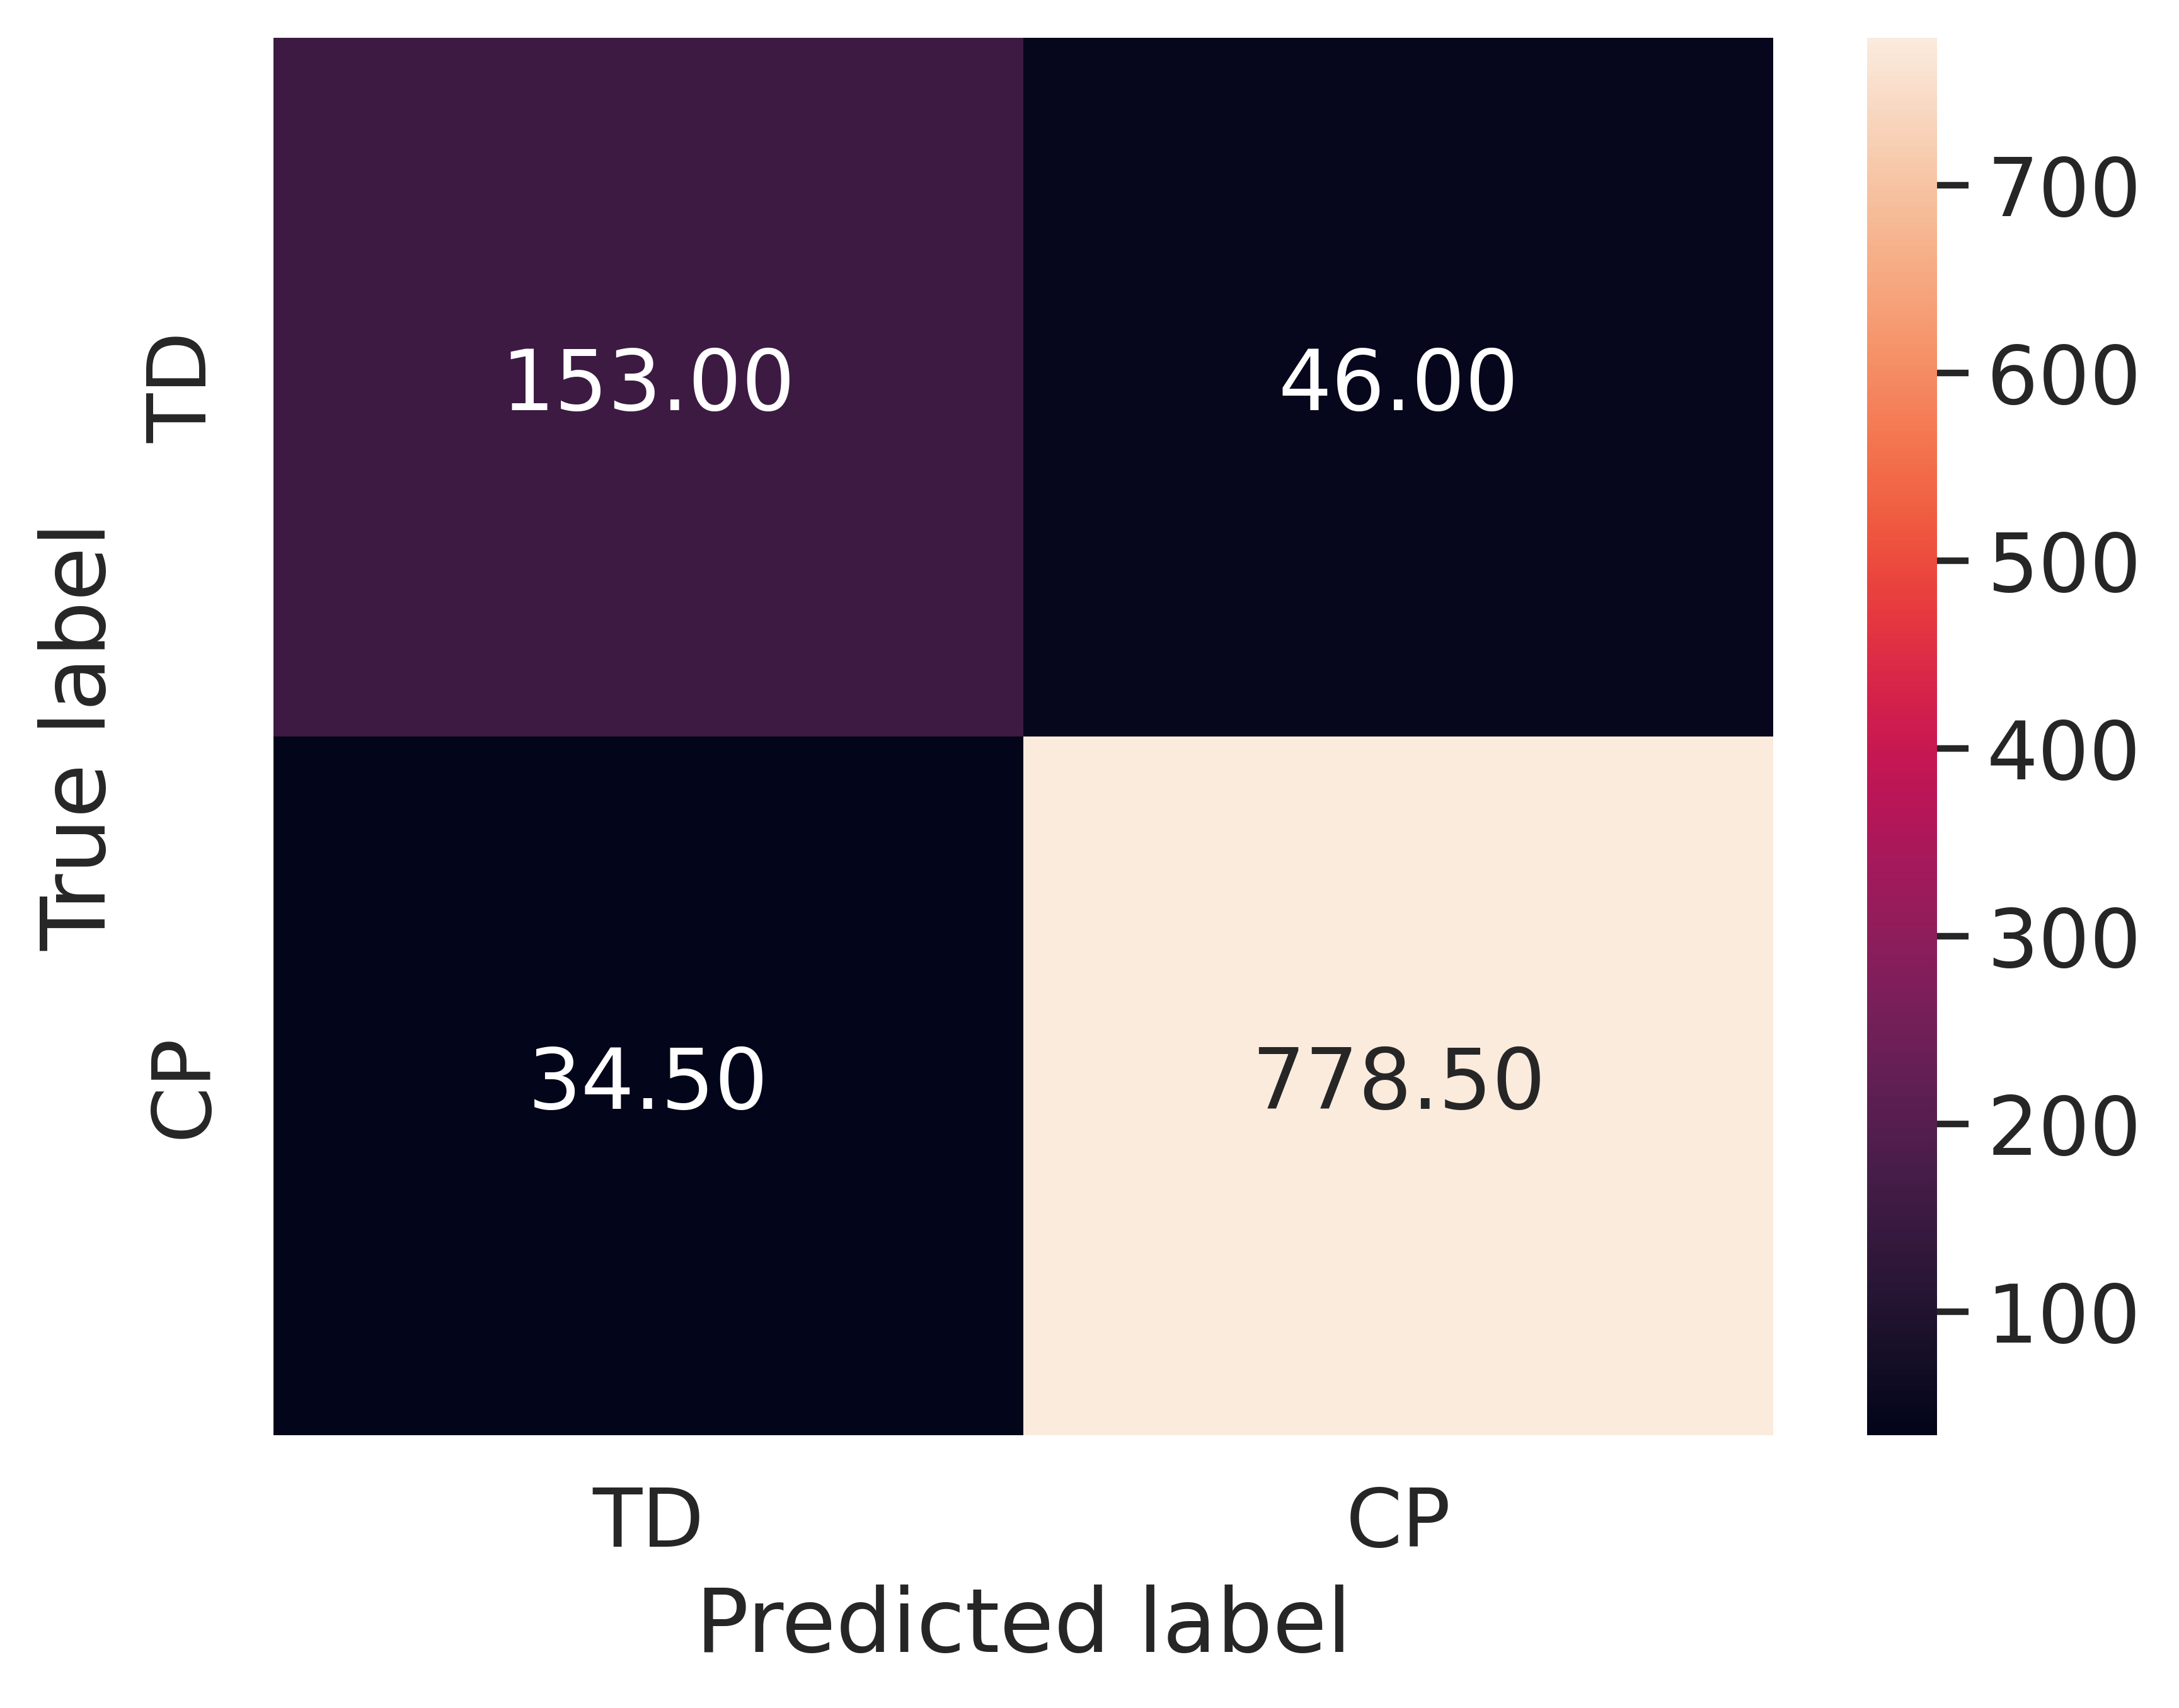

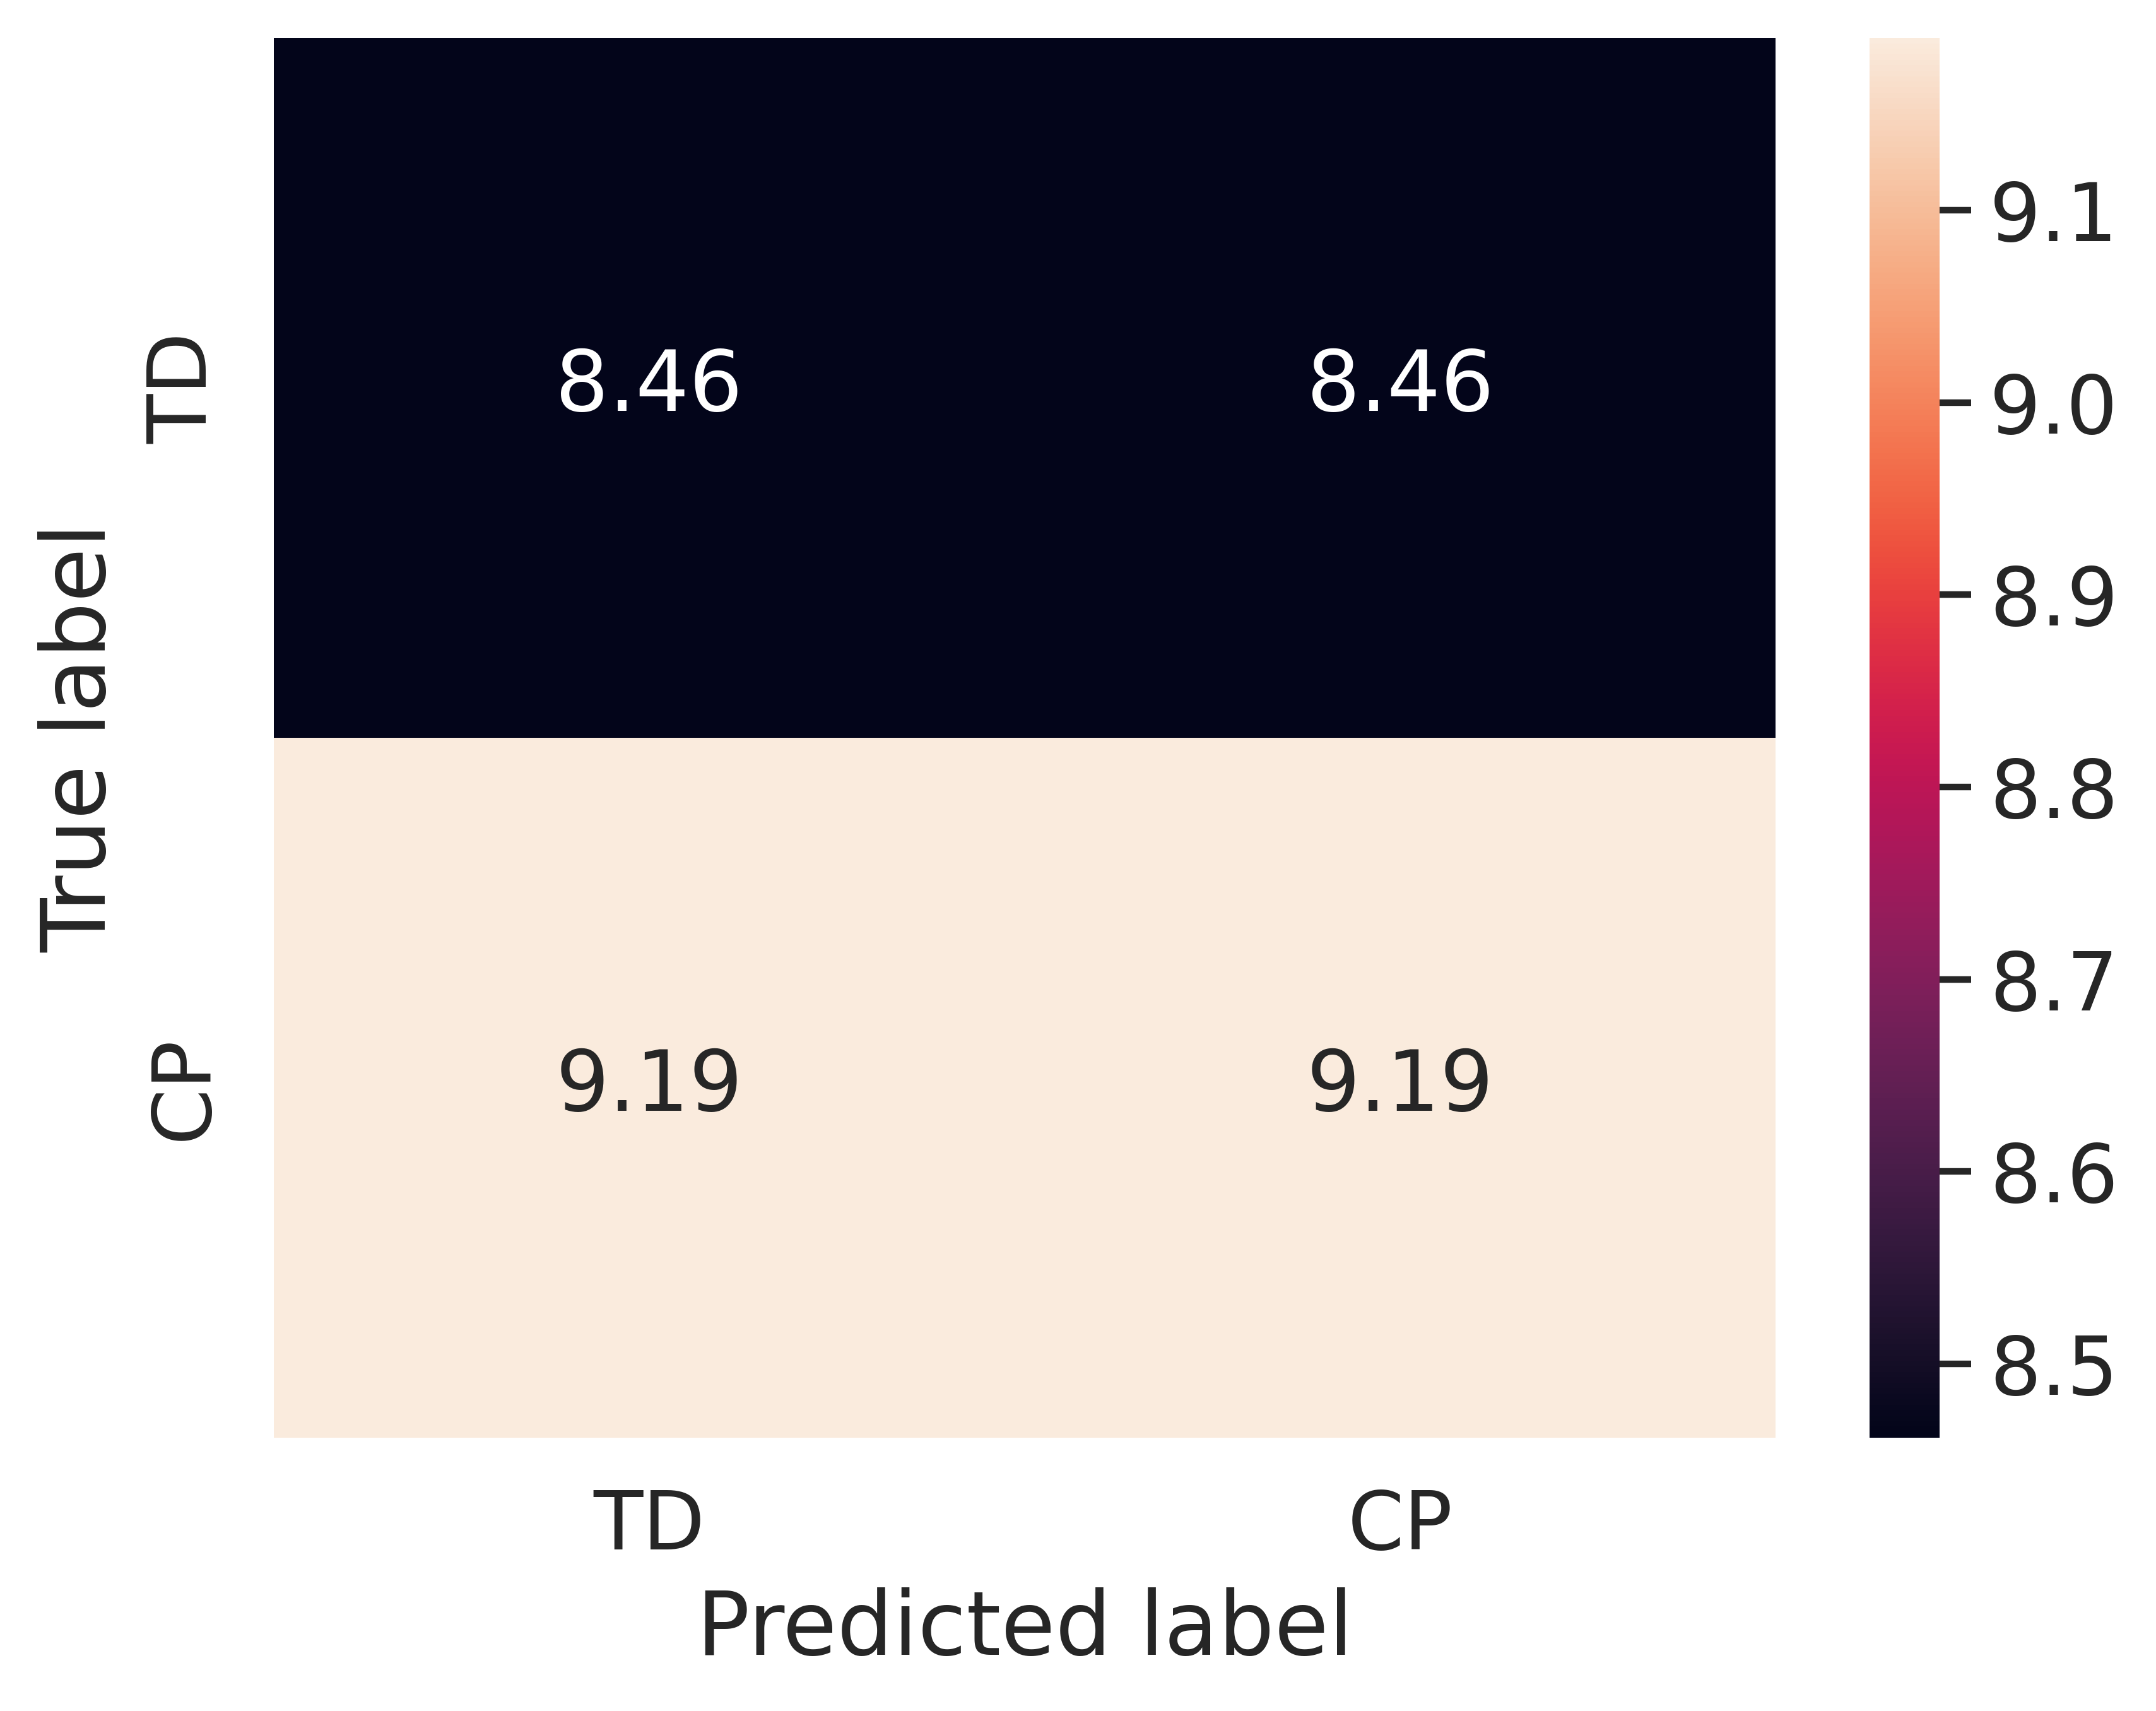

[[0.9204545454545455, 0.006528472987809851],
 [0.9575645756457563, 0.011303404811225232],
 [0.7688442211055276, 0.04252099658554005],
 [0.9508298991000339, 0.004133907442912626],
 [0.8632043983756421, 0.017614351359091226]]

In [14]:
out = np.load( './new_train_lrR_ET_TDvsCPu_full_5_ResNet/prediction.npy')
print_result_bundle_i_cycles(out,y_d,x_test,cycle_end_idx,label_list=['TD', 'CP'],n_model=10)

## Load the evaluation results and evaluate the model by subjects. Plot the confusion matrix and std of confusion matrix 

(array([ 4, 21, 31, 50, 55, 59]),)
(array([ 4, 16, 21, 55]),)
(array([ 4, 16, 21, 38, 55]),)
(array([ 4, 16, 21, 23, 31, 42, 59]),)
(array([ 1,  4, 16, 21, 55]),)
(array([ 4, 21, 55]),)
(array([ 4, 16, 21, 50]),)
(array([ 4, 16, 21, 23, 31, 42, 50, 55]),)
(array([ 4, 21, 31, 55]),)
(array([ 4, 16, 42, 55]),)
accuracy
[0.9047619047619048, 0.9365079365079365, 0.9206349206349206, 0.8888888888888888, 0.9206349206349206, 0.9523809523809523, 0.9365079365079365, 0.873015873015873, 0.9365079365079365, 0.9365079365079365]
0.9206349206349207
0.02354348726062115
confusion matrix
[array([[14,  4],
       [ 2, 43]]), array([[16,  2],
       [ 2, 43]]), array([[16,  2],
       [ 3, 42]]), array([[12,  6],
       [ 1, 44]]), array([[16,  2],
       [ 3, 42]]), array([[17,  1],
       [ 2, 43]]), array([[15,  3],
       [ 1, 44]]), array([[12,  6],
       [ 2, 43]]), array([[16,  2],
       [ 2, 43]]), array([[15,  3],
       [ 1, 44]])]
[[14.9  3.1]
 [ 1.9 43.1]]
[[1.64012195 1.64012195]
 [0.7       

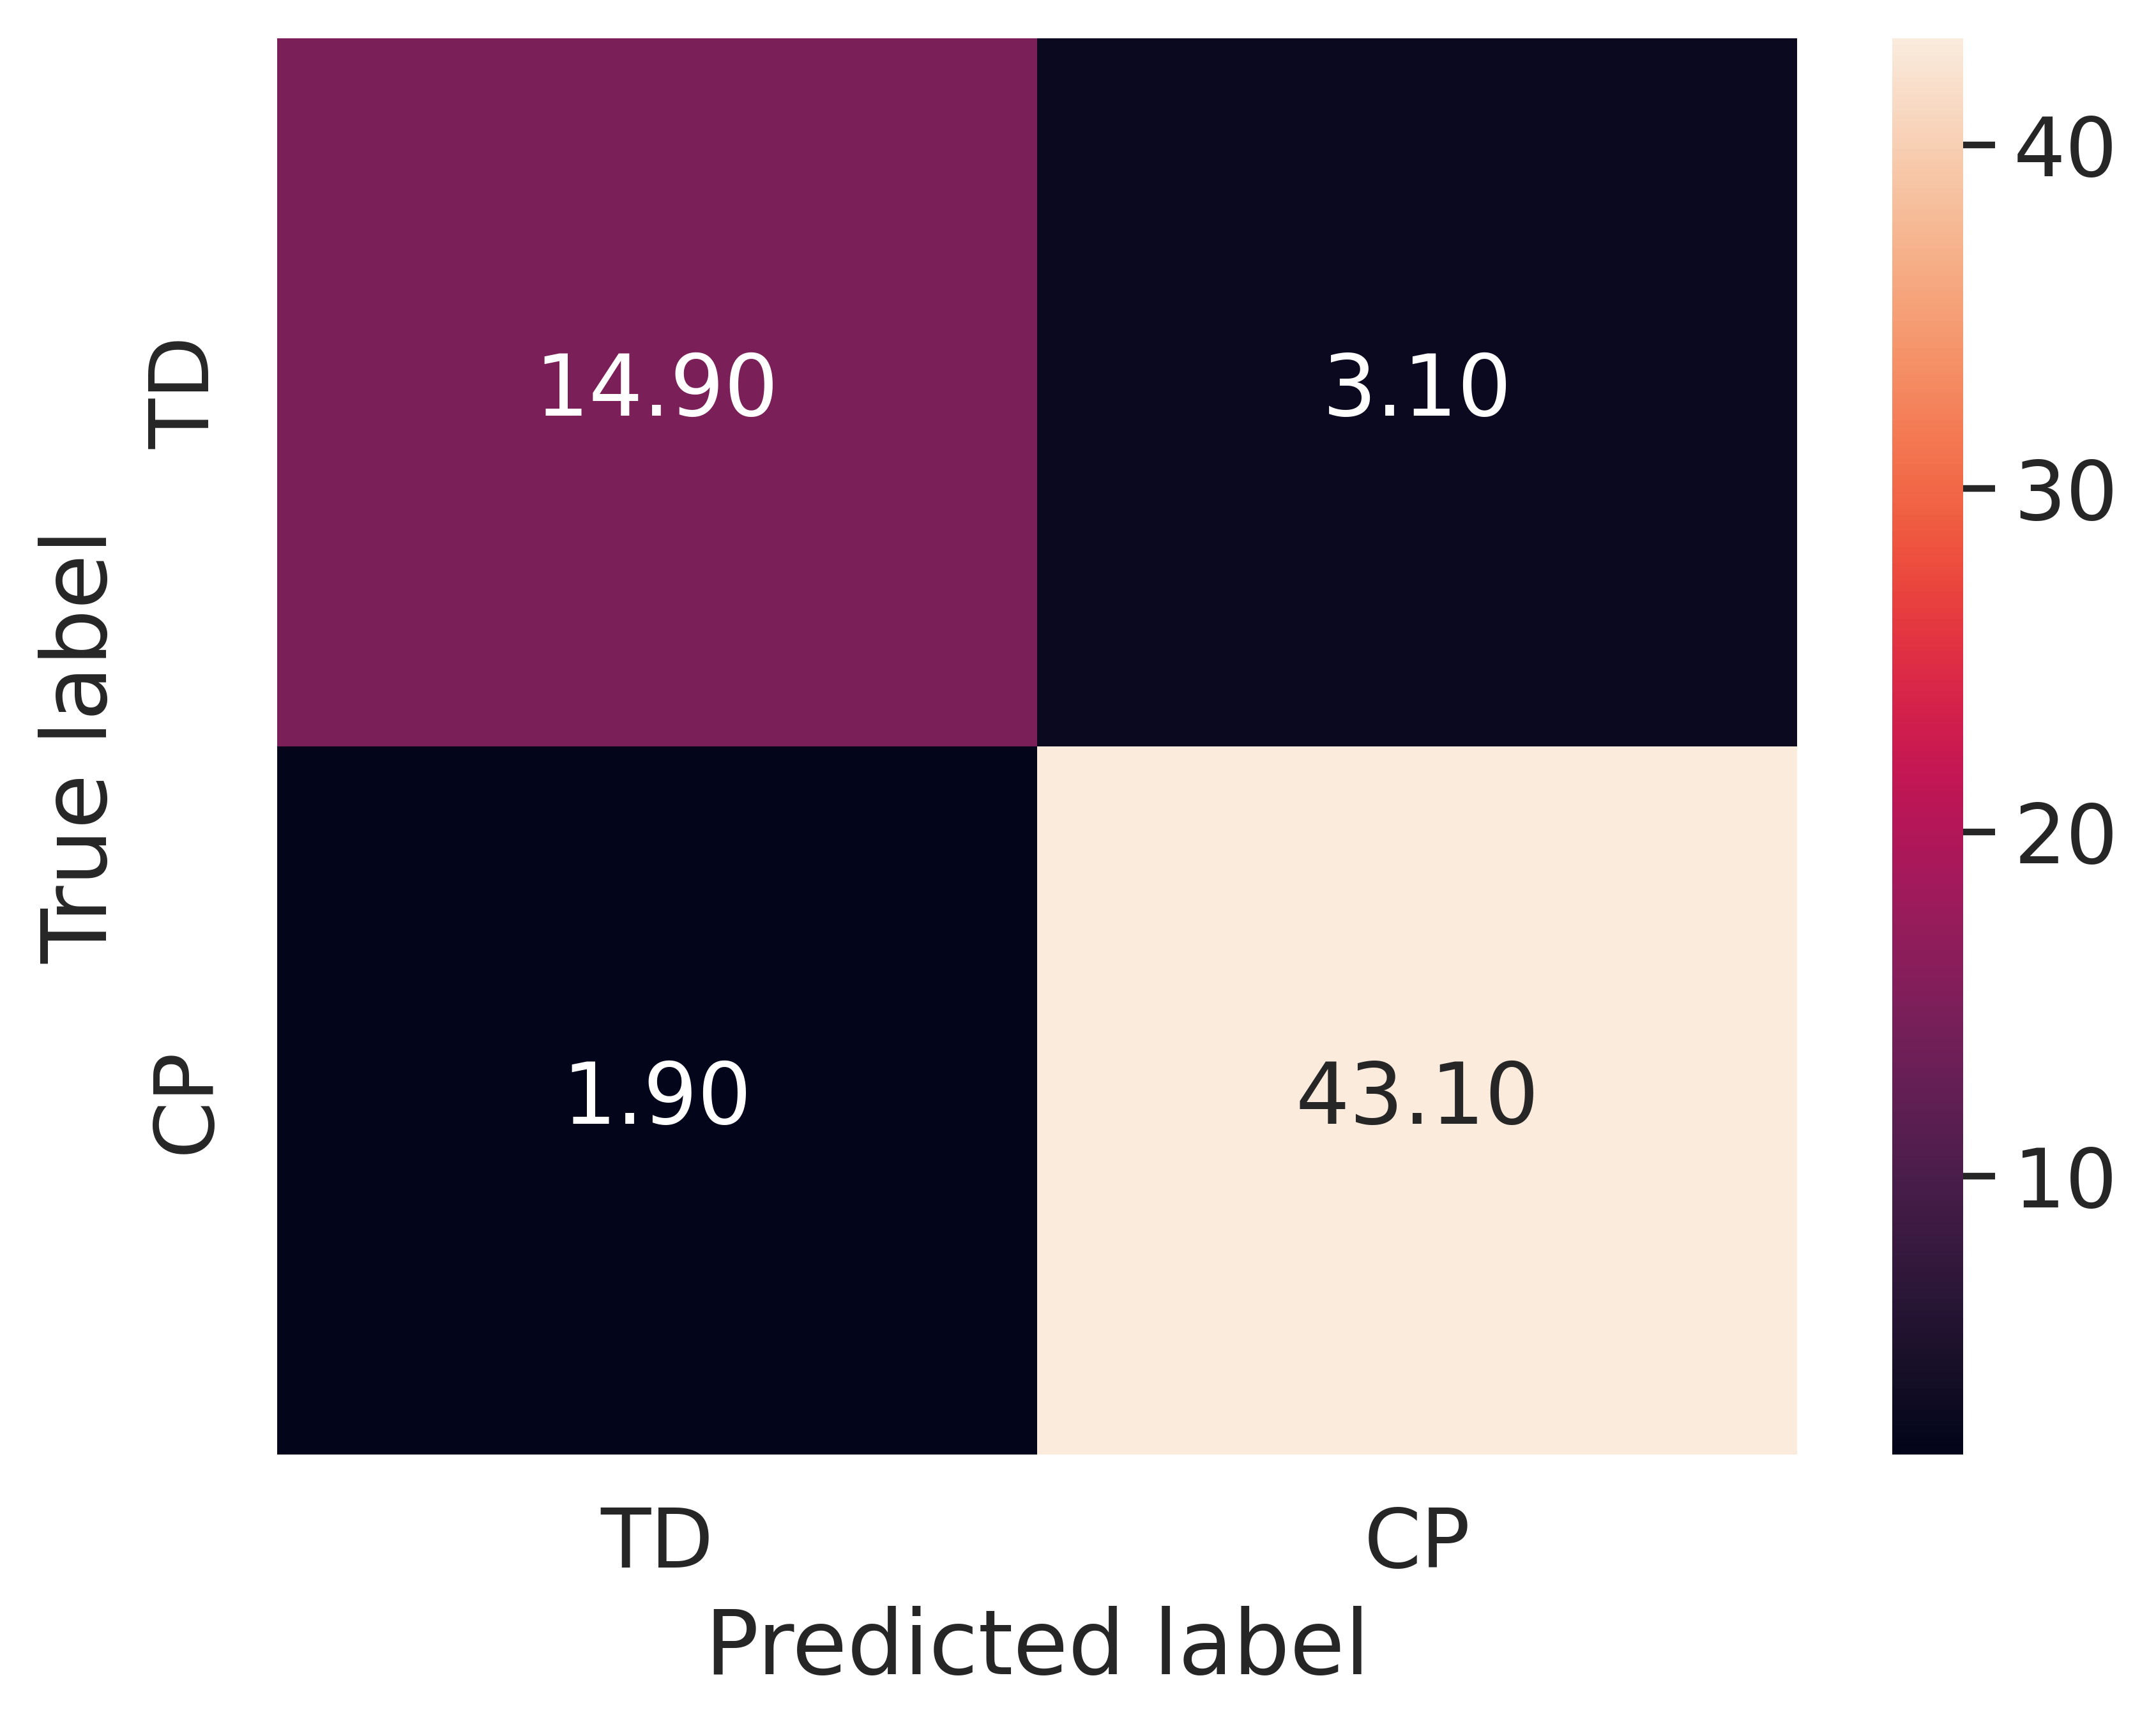

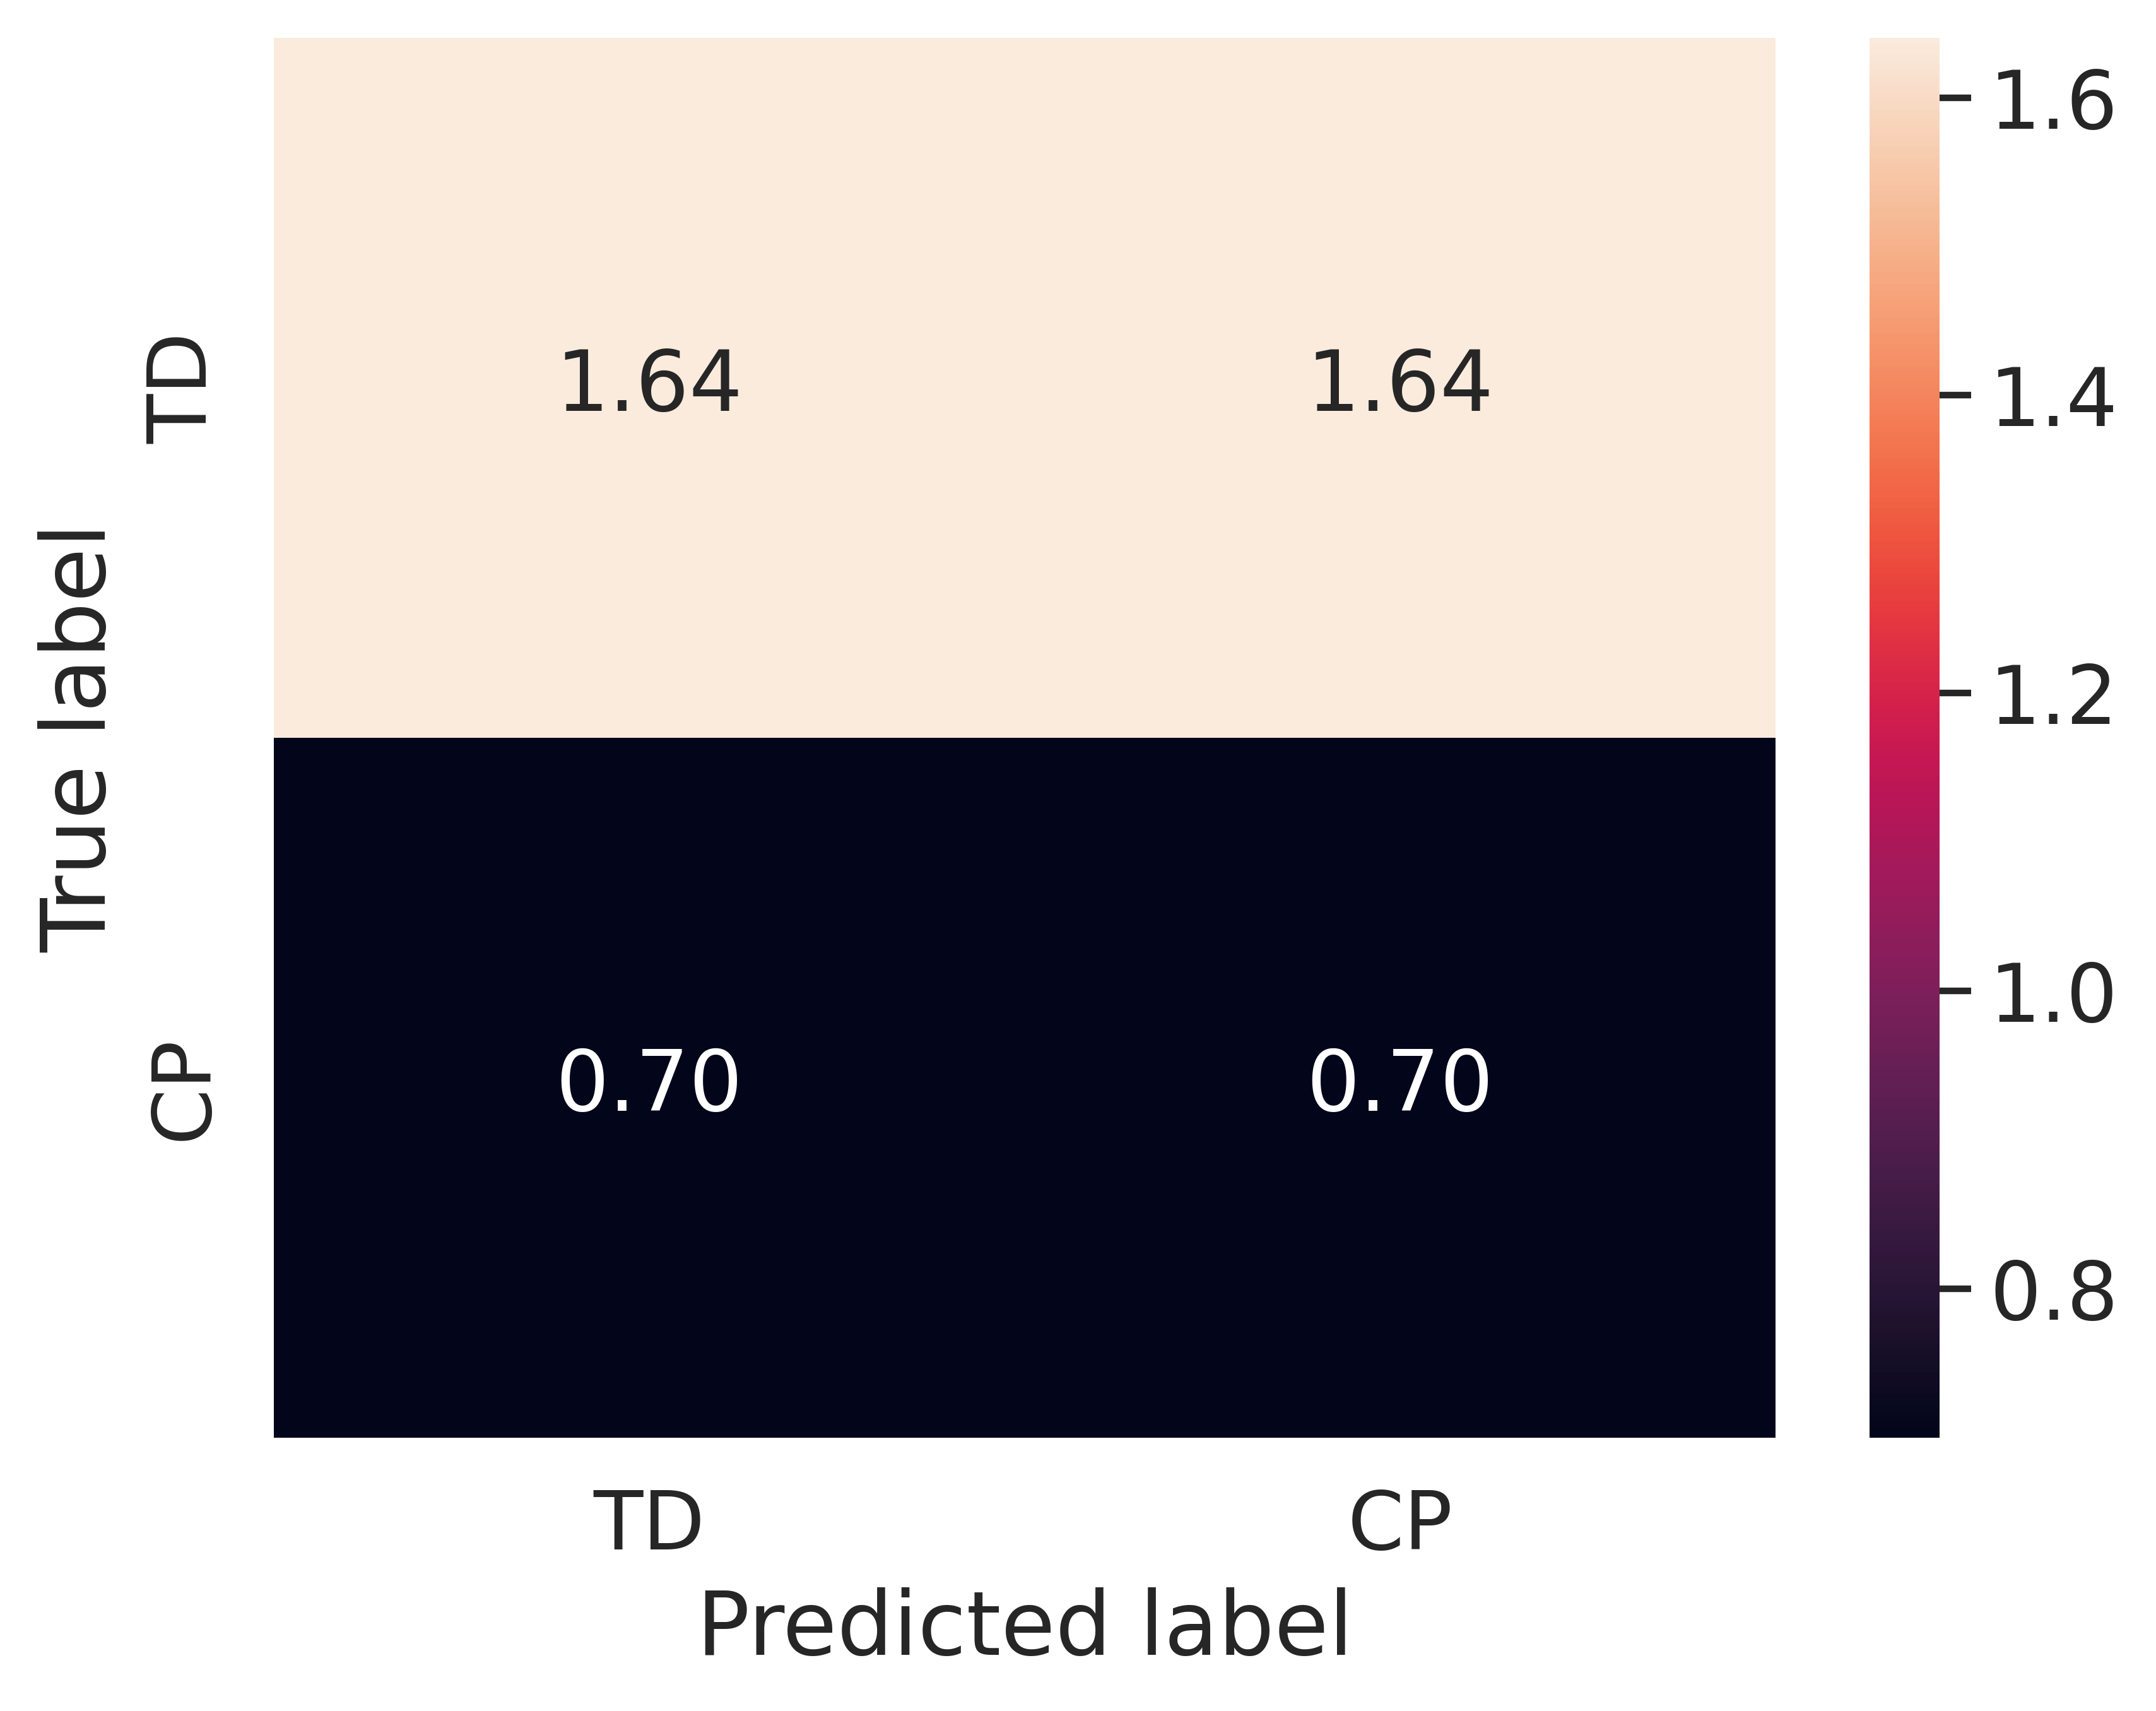

[[0.9206349206349207, 0.02354348726062115],
 [0.9577777777777777, 0.015555555555555536],
 [0.8277777777777778, 0.0911178859269818],
 [0.9454079188832256, 0.015174664155844989],
 [0.8927777777777777, 0.0428210459389847]]

In [15]:
print_result_bundle_i_subjects(out,y_d,x_test, y_test,cycle_end_idx,label_list=['TD', 'CP'],n_model=10)